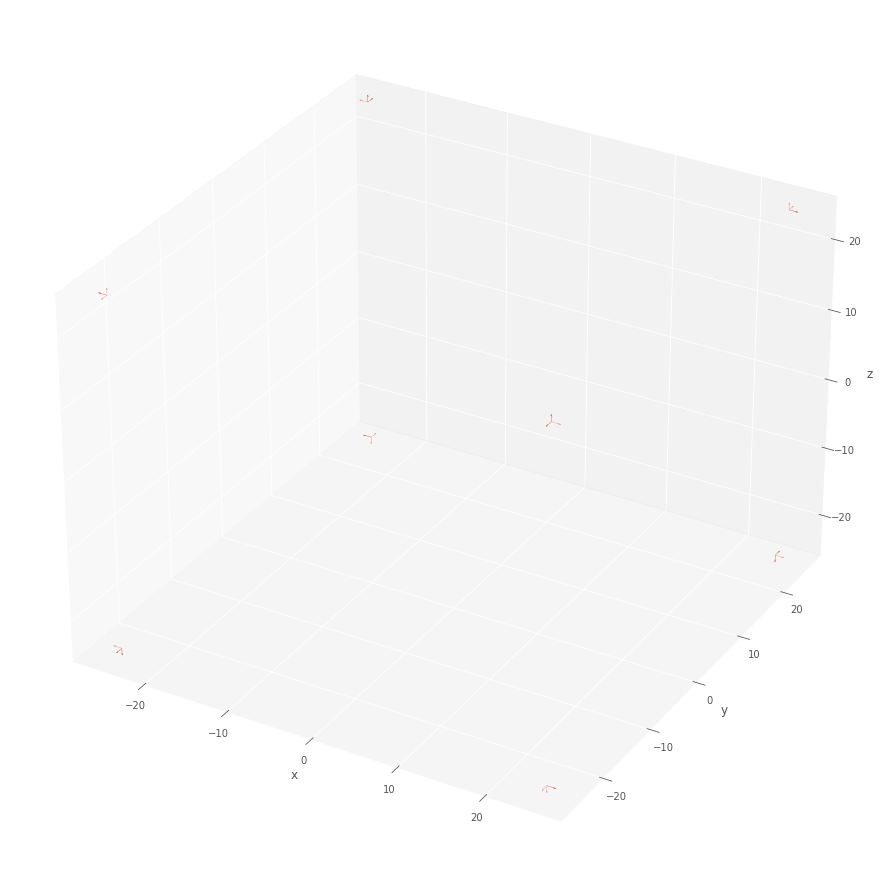

In [6]:
%matplotlib inline

''' Input style
into:0/1,is_reflect:0/1,p:x y z,in:x y z,dir:x y z,normal:x y z

'''

import numpy as np
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

class float3:
    def __init__(self, x, y, z):
        self.x = x
        self.y = y
        self.z = z
    
    # +
    def __iadd__(self, other):
        return float3(self.x + other.x, self.y + other.y, self.z + other.z)
    def __add__(self, other):
        return float3(self.x + other.x, self.y + other.y, self.z + other.z)
    
    # -
    def __sub__(self, other):
        return float3(self.x - other.x, self.y - other.y, self.z - other.z)
    def __isub__(self, other):
        return float3(self.x - other.x, self.y - other.y, self.z - other.z)
    
    # *
    def __mul__(self, t):
        return float3(self.x*t, self.y*t, self.z*t)
    
    # /
    def __truediv__(self, t):
        if t == 0:
            return self
        else:
            return self * (1/t)
    def length_squared(self):
        return self.x*self.x + self.y*self.y + self.z*self.z
        
    def length(self):
        return math.sqrt(self.length_squared())
    
    def __str__(self):
        return '{} {} {}'.format(self.x, self.y, self.z)
    
def dot(v1, v2):
    return v1.x*v2.x + v1.y*v2.y + v1.z*v2.z

def normalize(v):
    return v / v.length()

def extract_intersect_config(line):
    '''
    config (string)
    '''
    elems = line.split(',')
    config = dict()
    
    bool_names = ['into', 'is_reflect']
    float3_names = ['p', 'p0', 'p1', 'p2', 'dir', 'normal', 'in']
    
    for e in elems:
        if ":" in e:
            name, data = e.split(':')
            if name in bool_names:
                config[name] = int(data)
            elif name in float3_names:
                x, y, z = data.split(' ')
                x, y, z = float(x), float(y), float(z)
                config[name] = float3(x, y, z)
    return config
            
def is_into(p, indir, sphere):
    oc = p - sphere['position']
    if (oc + indir).length() < sphere['radius']:
        return True
    return False

def prepare_3dplot():
    plt.style.use('ggplot')
    plt.rcParams["axes.facecolor"] = 'white'
    fig = plt.figure(figsize=(16, 16))
    axes = fig.gca(projection='3d')
    
    return fig, axes

def is_normal_reversed(p, n, sphere):
#     print(p, n, p + n - sphere['position'])
    if (p + n - sphere['position']).length() < sphere['radius']:
        return True
    else:
        return False
    
def plot_normal(config, axes, scale=10, orig_name='p'):
    p = config[orig_name]*scale
    n = config['normal']
    
    axes.set(xlabel='x', ylabel='y', zlabel='z')
    axes.quiver(p.x, p.y, p.z, n.x, n.y, n.z, linewidth=0.2)
    
def plot_intersect(config, axes, dir_names, scale=10):
    p = config['p']*scale
    
    for d in dir_names:
        v = config[d]
        axes.quiver(p.x, p.y, p.z, v.x, v.y, v.z, linewidth=0.2)

# ref(plot vector): https://sabopy.com/py/matplotlib_3d_13/
def plot_intersect_with_vector(config, axes, scale=10, sphere=None):
    
    # Pass the config to variables
    is_into = intersect_config['into']
    is_reflect = intersect_config['is_reflect']
    p = intersect_config['p'] * scale
    outdir = intersect_config['dir']
    n = intersect_config['normal']
    indir = intersect_config['in']
    in2p = p - indir
    
    # Make the direction data for the arrows
    axes.set(xlabel='x', ylabel='y', zlabel='z')
    axes.quiver(p.x, p.y, p.z, n.x, n.y, n.z, linewidth=0.2);
    
def main():    
    datapath = "../../cube.log"
    with open(datapath, 'r') as log:
        lines = log.readlines()

    in_cnt = 0
    n_in_cnt = 0
    cnt = 0
    fig, axes = prepare_3dplot()
    for l in lines:
        config = extract_intersect_config(l)
        if not 'p0' in config.keys():
            continue
        for p in ['p0', 'p1', 'p2']:
            plot_normal(config, axes, orig_name=p)
        cnt += 1
#     print(in_cnt / len(lines))
    plt.show()
#     print(n_in_cnt / cnt)
#     plt.savefig('figure.png')
            
if __name__ == "__main__":
    main()